In [1]:
!hdfs dfsadmin -fs hdfs://nn:9000/ -report

Configured Capacity: 25821052928 (24.05 GB)
Present Capacity: 13521240064 (12.59 GB)
DFS Remaining: 13322752000 (12.41 GB)
DFS Used: 198488064 (189.29 MB)
DFS Used%: 1.47%
Replicated Blocks:
	Under replicated blocks: 17
	Blocks with corrupt replicas: 0
	Missing blocks: 0
	Missing blocks (with replication factor 1): 0
	Low redundancy blocks with highest priority to recover: 17
	Pending deletion blocks: 0
Erasure Coded Block Groups: 
	Low redundancy block groups: 0
	Block groups with corrupt internal blocks: 0
	Missing block groups: 0
	Low redundancy blocks with highest priority to recover: 0
	Pending deletion blocks: 0

-------------------------------------------------
Live datanodes (1):

Name: 192.168.64.3:9866 (project-5-p5-rfwong07-dn-1.project-5-p5-rfwong07_default)
Hostname: 90e64da7e810
Decommission Status : Normal
Configured Capacity: 25821052928 (24.05 GB)
DFS Used: 198488064 (189.29 MB)
Non DFS Used: 12283035648 (11.44 GB)
DFS Remaining: 13322752000 (12.41 GB)
DFS Used%: 0.77%

In [2]:
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

# Part 1: Filtering: RDDs, DataFrames, and Spark
Inside your p5.ipynb notebook, create a Spark session (note we're enabling Hive on HDFS):

In [3]:
#Import statements
#import for part1
from pyspark.sql import SparkSession

#import for part3
import matplotlib.pyplot as plt

#import for part4
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

In [4]:

spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/05 23:36:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# TODO: modify to treat the first row as a header
# TODO: modify to infer the schema
banks_df = (spark.read.format("csv")
            .option("header", True)
            .option("inferSchema",True)
            .load("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv"))
banks_df

DataFrame[respondent_name: string, arid_2017: string, lei_2018: string, lei_2019: string, lei_2020: string]

In [6]:
#q1
#How many banks contain the words "The" and "National" (case sensitive) in their name? Use an RDD to answer.
filtered_rows_rdd = banks_df.rdd.filter(lambda x: "The" in x["respondent_name"] and "National" in x["respondent_name"])

#Display rdd count using .count()
filtered_rows_rdd.count()

106

In [7]:
#q2

#Same as Q1. This time, use a DataFrame (instead of RDD) to answer.

filtered_rows_df = banks_df.filter("respondent_name LIKE '%The%' and respondent_name LIKE '%National%'")

#Display df count using .count()
filtered_rows_df.count()

106

In [8]:
#q3
#Same as Q1. This time, use Spark SQL (instead of RDD) to answer.

#Load data to hive table
banks_df.write.saveAsTable("banks", mode="overwrite")

filtered_sql_query = spark.sql("""
SELECT COUNT(*)
FROM banks
WHERE respondent_name LIKE '%The%' and respondent_name LIKE '%National%'
""")

#Display sql query count using .collect then indexing
filtered_sql_query.collect()[0][0]

24/04/05 23:36:55 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/05 23:36:55 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/04/05 23:37:02 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/04/05 23:37:02 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@192.168.64.4
24/04/05 23:37:05 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
24/04/05 23:37:10 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/04/05 23:37:10 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
24/04/05 23:37:10 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/04/05 23:37:10

106

# Part 2: Hive Data Warehouse

In [9]:
"""You have already added a banks table to Hive (using the command we shared with you). 
Now, write similar code hdma-wi-2021.csv into a table called loans."""

#Create spark_df for hdma-wi-2021.csv
loans_df = (spark.read.format("csv")
            .option("header", True)
            .option("inferSchema",True)
            .load("hdfs://nn:9000/hdma-wi-2021.csv"))

#Write  hdma-wi-2021.csv into a table called loans with bucketBy 8 buckets on column county_code
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

24/04/05 23:37:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [10]:
#Cell to see parquet files of loans table
#!hdfs dfs -ls hdfs://nn:9000/user/hive/warehouse/loans

In [11]:
hive_view_list = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
 "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]

for view in hive_view_list:

    #Read the csv where the first row is header, and the Schema is inferred
    df = spark.read.option("header", "true").option("inferSchema","true").csv(f"hdfs://nn:9000/{view}.csv")

    #Create or replace temp view for Dataframe
    df.createOrReplaceTempView(view)

In [12]:
#q4

#What tables are in our warehouse?
pd_table = spark.sql("SHOW TABLES").toPandas() #Convert table to pandas

#tableName => key, isTemporary => value change to dict with key-value pair
pd_table.set_index("tableName")["isTemporary"].to_dict() 

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [13]:
#q5

#Use INNER JOIN on banks.lei_2020 and loans.lei
#filter by respondent name = 'First National Bank'
query_result = spark.sql("""
    SELECT COUNT(*)
    FROM banks
    INNER JOIN loans ON banks.lei_2020 = loans.lei 
    WHERE banks.respondent_name = 'First National Bank'
    """)

#Display the count with .collect and indexing
query_result.collect()[0][0]

6

In [14]:
#q6

#What does .explain("formatted") tell us about how Spark executes Q5?
#Show the output of .explain("formatted")
query_result.explain("formatted")

#Which table is sent to every executor via a BroadcastExchange operation?

#The banks table is sent to every BroadcastExchange operation we can see 
#this in the "BradcastExchange" steps in the output below for example:
#(5) BroadcastExchange
#Input [1]: [lei_2020#69]
#(18) BroadcastExchange
#Input [1]: [lei_2020#69]
#The column lei_2020 in the banks table is being broadcasted to every executor.

#Does the plan involve HashAggregates (depending on how you write the query, it may or may not)? 
#If so, which ones? And, if not, why?

#This involves HasAggregate operation as it is indicated in the plans below. Specifically
#they occur at steps 12 and 24 where the aggregate function' 'count' is being used, 
# and steps 15 and 25 are steps where results are being aggregated further.

== Physical Plan ==
AdaptiveSparkPlan (25)
+- == Final Plan ==
   * HashAggregate (15)
   +- ShuffleQueryStage (14), Statistics(sizeInBytes=32.0 B, rowCount=2)
      +- Exchange (13)
         +- * HashAggregate (12)
            +- * Project (11)
               +- * BroadcastHashJoin Inner BuildLeft (10)
                  :- BroadcastQueryStage (6), Statistics(sizeInBytes=8.0 MiB, rowCount=8)
                  :  +- BroadcastExchange (5)
                  :     +- * Project (4)
                  :        +- * Filter (3)
                  :           +- * ColumnarToRow (2)
                  :              +- Scan parquet spark_catalog.default.banks (1)
                  +- * Filter (9)
                     +- * ColumnarToRow (8)
                        +- Scan parquet spark_catalog.default.loans (7)
+- == Initial Plan ==
   HashAggregate (24)
   +- Exchange (23)
      +- HashAggregate (22)
         +- Project (21)
            +- BroadcastHashJoin Inner BuildLeft (20)
               :- Br

# Part 3: Grouping Rows

In [15]:
#q7
#What are the application counts for Wells Fargo applications for the ten counties where 
#Wells Fargo applications have the highest average loan amount?

avg_query = spark.sql("""
    SELECT NAME, COUNT(*)
    FROM loans
    INNER JOIN banks ON loans.lei = banks.lei_2018
    INNER JOIN counties ON loans.county_code = counties.STATE*1000 + counties.COUNTY
    WHERE respondent_name = 'Wells Fargo Bank, National Association'
    GROUP BY NAME
    ORDER BY AVG(loan_amount) DESC
    LIMIT 10
    """)
avg_wells_query_dict = avg_query.toPandas().set_index("NAME").to_dict()['count(1)'] #Set Index to NAME before turning to dict
avg_wells_query_dict

{'Sawyer': 38,
 'Door': 174,
 'Forest': 7,
 'Ozaukee': 389,
 'Bayfield': 33,
 'Waukesha': 1832,
 'Vilas': 68,
 'Dane': 729,
 'Oneida': 70,
 'Florence': 8}

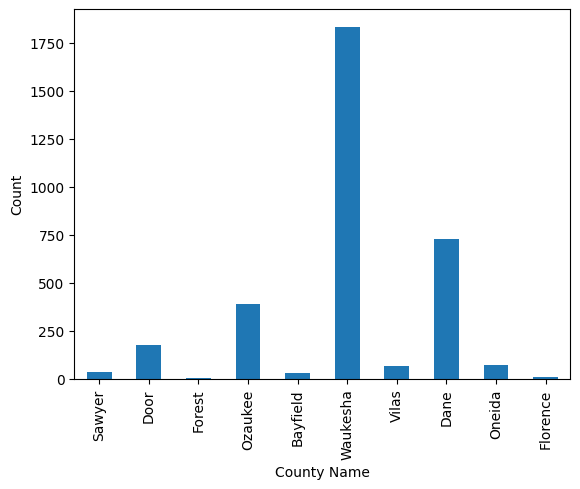

In [16]:
#This cell dipslays the counting dictionary from previous cell
avg_query.toPandas().plot(kind = "bar", x = 'NAME', y = 'count(1)', legend = None)
plt.xlabel("County Name")
plt.ylabel("Count")
#plt.title("Count of Applications of Counties with Wells Fargo") #Title not shown in example
plt.show()

In [17]:
#q8

#When computing a MEAN aggregate per group of loans, under what situation (when) do we require network I/O between the partial_mean and mean operations?

#Try group by county_code
group_county_query = spark.sql("""
    SELECT county_code 
    FROM loans
    GROUP BY county_code
    """)
group_county_query.explain()

#Then try grouping by the lei column
group_lei_query = spark.sql("""
    SELECT lei 
    FROM loans
    GROUP BY lei
    """)
group_lei_query.explain()

#In group_lei_query there is this line "Exchange hashpartitioning(lei#988, 200)' which indicates that 
#there's an Exhange operation with the lei column. This indicates that the data is 
#being shuffled across the network to ensure that all the rows with the same lei are grouped properly.
#Whereas looking at the county_code group by query,  there is no Exchange operation, but at the very 
#end we see SelectedBucketsCount: 8 out of 8. Back in the beginning of part 2 we used bucketBy to 
#partition the county_code column into 8 partitions.  This means when we read the data back
#in we get an RDD that is already partitioned by counties. Thus, when we conduct GROUP BY
#on county_code we skip the network shuffle/exchange operation since multiple partitions
#don't have to be accessed to obtain information on certain county_codes. 

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#991], functions=[])
   +- HashAggregate(keys=[county_code#991], functions=[])
      +- FileScan parquet spark_catalog.default.loans[county_code#991] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string>, SelectedBucketsCount: 8 out of 8


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#988], functions=[])
   +- Exchange hashpartitioning(lei#988, 200), ENSURE_REQUIREMENTS, [plan_id=879]
      +- HashAggregate(keys=[lei#988], functions=[])
         +- FileScan parquet spark_catalog.default.loans[lei#988] Batched: true, Bucketed: false (bucket column(s) not read), DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [],

# Part 4: Machine Learning

In [18]:

# spark.sql("""
# SELECT *, action_taken.action_taken AS action_description
# FROM loans
# INNER JOIN action_taken ON loans.action_taken = action_taken.id
# """).rdd.take(1)[0]

df = spark.sql("""
SELECT loan_amount, CAST(income AS double), CAST(interest_rate AS double), action_taken
FROM loans
""").toPandas() #Convert to pandas to wrangle the data

# Fill missing values of all features with 0.0
df = df.fillna(0.0)

#Create label approval with values 1 if its 1 ("Loan Originated") and the rest are 0 (not "Loan Originated")
df["approval"] = (df['action_taken'] == 1).astype(int)

#Important Keep orders of columns as follow: "loan_amount", "income", "interest_rate", "approval"
df.drop(columns = ["action_taken"], inplace = True)

#Convert back to spark Dataframe
df = spark.createDataFrame(df)

#Then split df as follows: deterministic split
train, test = df.randomSplit([0.8, 0.2], seed=41) 

#Cache the train DataFrame
train.cache()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


DataFrame[loan_amount: double, income: double, interest_rate: double, approval: bigint]

In [19]:
#q9 

#How many loans are approved (approval = 1) in the train DataFrame?
approval_rows = train.rdd.filter(lambda x: 1 == x["approval"])
#Answer with a single number
approval_rows.count()


24/04/05 23:39:35 WARN TaskSetManager: Stage 49 contains a task of very large size (6989 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 23:39:48 WARN TaskSetManager: Stage 50 contains a task of very large size (6989 KiB). The maximum recommended task size is 1000 KiB.


242907

In [21]:
#q10
#What is the accuracy of the random forest classifier with 10 trees on the test dataset?

#Use VectorAssembler to Combine hte feature columns into a single column
va = VectorAssembler(inputCols = ["loan_amount", "income", "interest_rate"], outputCol = "features")
va.transform(train).show()

#Train a RandomforestClassifier with 10 trees
rf = RandomForestClassifier(featuresCol = "features", labelCol ="approval", numTrees = 10)
random_forest_model = rf.fit(va.transform(train))

test_transformed = va.transform(test)
predictions = random_forest_model.transform(test_transformed)

#Total Count
total_predict_count = predictions.rdd.count()

#Find when rows of prediction = approval and then count them
correct_pred_rows = predictions.rdd.filter(lambda x : x["prediction"] == x["approval"])
correct_pred_count = correct_pred_rows.count()

#Calculate Average (accuracy)
accuracy = correct_pred_count / total_predict_count 

#Display the accuracy
accuracy

24/04/05 23:42:48 WARN TaskSetManager: Stage 71 contains a task of very large size (6989 KiB). The maximum recommended task size is 1000 KiB.


+-----------+------+-------------+--------+----------------+
|loan_amount|income|interest_rate|approval|        features|
+-----------+------+-------------+--------+----------------+
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|       0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|    

24/04/05 23:42:48 WARN TaskSetManager: Stage 72 contains a task of very large size (7017 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 23:42:50 WARN TaskSetManager: Stage 75 contains a task of very large size (6989 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 23:42:50 WARN TaskSetManager: Stage 76 contains a task of very large size (7017 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 23:42:51 WARN TaskSetManager: Stage 77 contains a task of very large size (6989 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 23:42:52 WARN TaskSetManager: Stage 79 contains a task of very large size (6989 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 23:42:54 WARN TaskSetManager: Stage 81 contains a task of very large size (6989 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 23:42:56 WARN TaskSetManager: Stage 83 contains a task of very large size (7017 KiB). The maximum recommended task size is 1000 KiB.
24/04/

0.8929993991855627